In [ ]:
!pip install keras==2.3.0
!pip install tensorflow = 2.2.0

# Code for CMSC421 Final project written by Stefan Obradovic with help from Ian Yeh

In [606]:
import pandas as pd
import numpy as np
import math
import random

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Reshape, GRU, Bidirectional, RNN, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping

from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot

from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from sklearn import metrics

In [684]:
# name our columns
colnames = ['time', 'activityID', 'bpm'] + ['hand{}'.format(x) for x in range(13)] + ['chest{}'.format(x) for x in range(13)] + ['ankle{}'.format(x) for x in range(13)]

# exclude useless columns 
targetcols = set(range(0,54)).difference({16,17,18,19,33,34,35,36,50,51,52,53})

dataset = read_csv('PAMAP2_Dataset/Protocol/subject101.dat', sep=' ', names=colnames, usecols=targetcols)
    
dataset.loc[:,:] = dataset.loc[:,:].ffill()  #We forward fill all NaN values

In [685]:
dataset.columns

Index(['time', 'activityID', 'bpm', 'hand0', 'hand1', 'hand2', 'hand3',
       'hand4', 'hand5', 'hand6', 'hand7', 'hand8', 'hand9', 'hand10',
       'hand11', 'hand12', 'chest0', 'chest1', 'chest2', 'chest3', 'chest4',
       'chest5', 'chest6', 'chest7', 'chest8', 'chest9', 'chest10', 'chest11',
       'chest12', 'ankle0', 'ankle1', 'ankle2', 'ankle3', 'ankle4', 'ankle5',
       'ankle6', 'ankle7', 'ankle8', 'ankle9', 'ankle10', 'ankle11',
       'ankle12'],
      dtype='object')

In [686]:
pd.value_counts([j-i for i, j in zip(dataset['activityID'][:-1], dataset['activityID'][1:])])

 0     376391
 1          4
-13         2
 12         2
 17         1
 4          1
 5          1
 6          1
 7          1
 13         1
 16         1
-3          1
-4          1
-24         1
-17         1
-16         1
-12         1
-7          1
-6          1
-5          1
 24         1
dtype: int64

In [687]:
pd.unique(dataset['activityID'])

array([ 0,  1,  2,  3, 17, 16, 12, 13,  4,  7,  6,  5, 24])

In [692]:
class_map = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    12: 8,
    13: 9,
    16: 10,
    17: 11,
    24: 12
}

In [693]:
for ind in dataset.index:
     dataset['activityID'][ind] = class_map[dataset['activityID'][ind]]

/Users/stefan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [694]:
copy = dataset.copy()

In [695]:
# prepare data for lstm
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [696]:
def preprocess(dataset):
    one_hot = pd.get_dummies(dataset['activityID'])
    dataset = dataset.drop('activityID',axis = 1)
    dataset = dataset.join(one_hot)    
    
    # load dataset
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)

    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[*range(53, 104-11)]], axis=1, inplace=True)
    
    values = reframed.values
    n  = reframed.shape[0]
    n_train_hours = 365 * 24
    
    train = values[:-100000, :]
   # val = values[math.floor(n*.7):math.floor(n*.8), :]
    test = values[-150000:, :]
    val = test[:40000, :]
    test = test[40000:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-12], train[:, -13:-1]
    val_X, val_y = val[:, :-12], val[:, -13:-1]
    test_X, test_y = test[:, :-12], test[:, -13:-1]


    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    #train_X, test_X = test_X, train_X
    #train_y, test_y = test_y, train_y

    return (train_X, train_y, val_X, val_y, test_X, test_y)

In [697]:
def notanumber(percent, dataset):
    n = dataset.shape[0]
    m = dataset.shape[1] - 2
    percent = percent * n * m
    lst = random.sample(range(0, n*m), math.floor(percent))
    print(lst[1:5])
    for i in lst: 
        c = i / n
        r = i % n
        c = math.floor(c) + 2
        dataset.iloc[r,c] = np.nan
    return dataset

In [698]:
def noise(percent, sigma, dataset):
    n = dataset.shape[0]
    m = dataset.shape[1] - 2
    noise = np.random.normal(0,sigma,1)
    percent = percent * n * m
    lst = random.sample(range(0, n*m), math.floor(percent))
    for i in lst: 
        c = i / n
        r = i % n
        c = math.floor(c) + 2
        dataset.iloc[r,c] += noise
    return dataset

In [699]:
def drop(percent, dataset):
    n = dataset.shape[0]
    percent = percent * n
    lst = random.sample(range(0, n-1), math.floor(percent))
    #print(lst)
    rows = dataset.index[lst]
    dataset.drop(rows, inplace = True)
    return dataset

# LSTM

In [700]:
def lstm(train_X, train_y, val_X, val_y, test_X, test_y):
    # design network
    model = Sequential()
    model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_data=(val_X, val_y), verbose=2, shuffle=False)
    
    
    testPredict = model.predict(test_X)
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([test_y])
    
    maxes_test = test_y.max(axis=1)
    indices_test = list()
    count = 0
    for row in test_y:
        indices_test.append(list(row).index(maxes_test[count]))
        count += 1
        
    maxes_pred = testPredict.max(axis=1)
    indices_pred = list()
    count = 0
    for row in testPredict:
        indices_pred.append(list(row).index(maxes_pred[count]))
        count += 1

    testScore = math.sqrt(accuracy_score(indices_test, indices_pred)) #/test_y.shape[0]
    print('Test Accuracy: ' + str(testScore))
    
    #gru_prediction = model.evaluate(test_X, test_y)
    #print("RNN GRU: " + str(gru_prediction) + "\n\n")
    
    #rnn_proba_gru = model.predict(test_X) #.squeeze()  # Prediction
    #rnn_auc_gru = metrics.roc_auc_score(test_y, rnn_proba_gru[:, 0])  # Calculate AUROC score
    #print("AUC: " + rnn_auc_gru)

    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()
    
    return testScore

# GRU

In [701]:
def gru(train_X, train_y, val_X, val_y, test_X, test_y):
    # design network
    model = Sequential()
    model.add(GRU(30, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_data=(val_X, val_y), verbose=2, shuffle=False)

    
    testPredict = model.predict(test_X)
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([test_y])
    
    maxes_test = test_y.max(axis=1)
    indices_test = list()
    count = 0
    for row in test_y:
        indices_test.append(list(row).index(maxes_test[count]))
        count += 1
        
    maxes_pred = testPredict.max(axis=1)
    indices_pred = list()
    count = 0
    for row in testPredict:
        indices_pred.append(list(row).index(maxes_pred[count]))
        count += 1

    testScore = math.sqrt(accuracy_score(indices_test, indices_pred)) #/test_y.shape[0]
    print('Test Accuracy: ' + str(testScore))
    
    
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()
    return testScore

# Simple RNN

In [702]:
def simpleRNN(train_X, train_y, val_X, val_y, test_X, test_y):
    # design network
    model = Sequential()
    model.add(SimpleRNN(30, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_data=(val_X, val_y), verbose=2, shuffle=False)

    
    testPredict = model.predict(test_X)
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([test_y])
    
    maxes_test = test_y.max(axis=1)
    indices_test = list()
    count = 0
    for row in test_y:
        indices_test.append(list(row).index(maxes_test[count]))
        count += 1
        
    maxes_pred = testPredict.max(axis=1)
    indices_pred = list()
    count = 0
    for row in testPredict:
        indices_pred.append(list(row).index(maxes_pred[count]))
        count += 1

    testScore = math.sqrt(accuracy_score(indices_test, indices_pred)) #/test_y.shape[0]
    print('Test Accuracy: ' + str(testScore))
    
    
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()
    return testScore

# Naive

In [703]:
def naive(dataset): 
    one_hot = pd.get_dummies(dataset['activityID'])
    dataset = dataset.drop('activityID',axis = 1)
    dataset = dataset.join(one_hot)  
    
    
    # load dataset
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    
    reframed.drop(reframed.columns[[*range(0, 41)]], axis=1, inplace=True)
    reframed.drop(reframed.columns[[*range(13, 54)]], axis=1, inplace=True)
    
    y_pred = reframed.iloc[: , :13]
    y_target = reframed.iloc[: , 13:]
    
    testScore = math.sqrt(accuracy_score(y_target, y_pred)) #/test_y.shape[0]
    print('Test Accuracy: ' + str(testScore))
    
    return testScore


# EXPERIMENT 1:

Test Accuracy: 0.9999650437407565
(257596, 1, 56) (257596, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
LSTM
Epoch 1/10
1718/1718 - 4s - loss: 0.9239 - acc: 0.7579 - val_loss: 3.1533 - val_acc: 0.1760
Epoch 2/10
1718/1718 - 4s - loss: 0.3327 - acc: 0.9060 - val_loss: 2.5936 - val_acc: 0.4706
Epoch 3/10
1718/1718 - 4s - loss: 0.1405 - acc: 0.9578 - val_loss: 2.0059 - val_acc: 0.4706
Epoch 4/10
1718/1718 - 4s - loss: 0.0465 - acc: 0.9860 - val_loss: 0.7429 - val_acc: 0.4706
Epoch 5/10
1718/1718 - 4s - loss: 0.0131 - acc: 0.9999 - val_loss: 0.0648 - val_acc: 0.9999
Epoch 6/10
1718/1718 - 4s - loss: 0.0044 - acc: 0.9999 - val_loss: 0.0066 - val_acc: 0.9999
Epoch 7/10
1718/1718 - 4s - loss: 0.0018 - acc: 0.9999 - val_loss: 0.0019 - val_acc: 0.9999
Epoch 8/10
1718/1718 - 4s - loss: 9.3095e-04 - acc: 0.9999 - val_loss: 8.5534e-04 - val_acc: 0.9999
Epoch 9/10
1718/1718 - 5s - loss: 6.2348e-04 - acc: 0.9999 - val_loss: 4.8266e-04 - val_acc: 0.9999
Epoch 10/10
1718/1718 - 4s - los

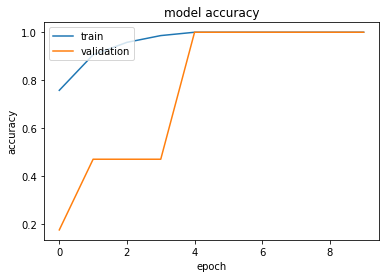

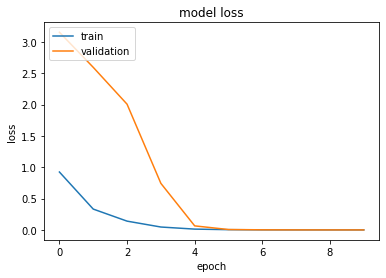

GRU
Epoch 1/10
1718/1718 - 5s - loss: 0.8202 - acc: 0.7914 - val_loss: 2.4048 - val_acc: 0.1760
Epoch 2/10
1718/1718 - 5s - loss: 0.3121 - acc: 0.9128 - val_loss: 2.5925 - val_acc: 0.4706
Epoch 3/10
1718/1718 - 5s - loss: 0.1207 - acc: 0.9617 - val_loss: 2.4432 - val_acc: 0.4706
Epoch 4/10
1718/1718 - 5s - loss: 0.0495 - acc: 0.9823 - val_loss: 1.9179 - val_acc: 0.4706
Epoch 5/10
1718/1718 - 5s - loss: 0.0172 - acc: 0.9968 - val_loss: 0.9115 - val_acc: 0.4706
Epoch 6/10
1718/1718 - 5s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0965 - val_acc: 0.9999
Epoch 7/10
1718/1718 - 4s - loss: 0.0023 - acc: 0.9999 - val_loss: 0.0098 - val_acc: 0.9999
Epoch 8/10
1718/1718 - 5s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0019 - val_acc: 0.9999
Epoch 9/10
1718/1718 - 4s - loss: 6.2502e-04 - acc: 0.9999 - val_loss: 6.6251e-04 - val_acc: 0.9999
Epoch 10/10
1718/1718 - 5s - loss: 4.4237e-04 - acc: 0.9999 - val_loss: 3.4621e-04 - val_acc: 1.0000
Test Accuracy: 0.7080125833499135


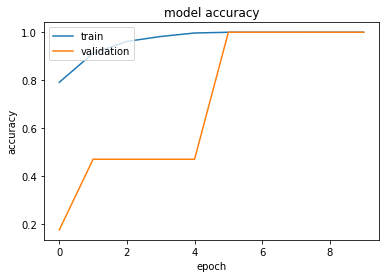

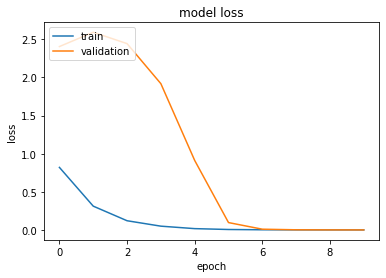

RNN
Epoch 1/10
1718/1718 - 3s - loss: 0.6887 - acc: 0.8222 - val_loss: 2.9592 - val_acc: 0.1760
Epoch 2/10
1718/1718 - 2s - loss: 0.2613 - acc: 0.9210 - val_loss: 2.5467 - val_acc: 0.4706
Epoch 3/10
1718/1718 - 3s - loss: 0.1242 - acc: 0.9596 - val_loss: 2.3772 - val_acc: 0.4706
Epoch 4/10
1718/1718 - 4s - loss: 0.0586 - acc: 0.9789 - val_loss: 1.9521 - val_acc: 0.4706
Epoch 5/10
1718/1718 - 3s - loss: 0.0261 - acc: 0.9936 - val_loss: 1.1696 - val_acc: 0.4706
Epoch 6/10
1718/1718 - 2s - loss: 0.0112 - acc: 0.9999 - val_loss: 0.2061 - val_acc: 0.9927
Epoch 7/10
1718/1718 - 3s - loss: 0.0044 - acc: 0.9999 - val_loss: 0.0233 - val_acc: 0.9999
Epoch 8/10
1718/1718 - 3s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0042 - val_acc: 0.9999
Epoch 9/10
1718/1718 - 3s - loss: 9.1570e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 10/10
1718/1718 - 3s - loss: 5.5154e-04 - acc: 0.9999 - val_loss: 4.3207e-04 - val_acc: 1.0000
Test Accuracy: 0.7080125833499135


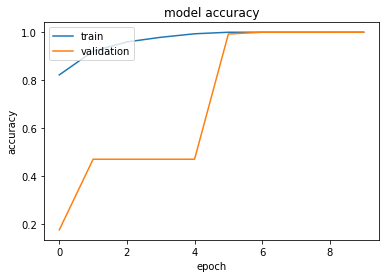

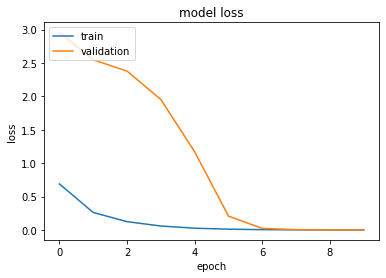

Test Accuracy: 0.9999631016733266
(238775, 1, 56) (238775, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
LSTM
Epoch 1/10
1592/1592 - 4s - loss: 0.9541 - acc: 0.7414 - val_loss: 2.1681 - val_acc: 0.0231
Epoch 2/10
1592/1592 - 4s - loss: 0.3466 - acc: 0.9000 - val_loss: 1.9429 - val_acc: 0.4987
Epoch 3/10
1592/1592 - 3s - loss: 0.1429 - acc: 0.9542 - val_loss: 1.6162 - val_acc: 0.4987
Epoch 4/10
1592/1592 - 4s - loss: 0.0444 - acc: 0.9877 - val_loss: 0.7876 - val_acc: 0.4987
Epoch 5/10
1592/1592 - 4s - loss: 0.0138 - acc: 0.9999 - val_loss: 0.1174 - val_acc: 0.9999
Epoch 6/10
1592/1592 - 3s - loss: 0.0049 - acc: 0.9999 - val_loss: 0.0088 - val_acc: 0.9999
Epoch 7/10
1592/1592 - 3s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0021 - val_acc: 0.9999
Epoch 8/10
1592/1592 - 3s - loss: 0.0011 - acc: 0.9999 - val_loss: 9.1043e-04 - val_acc: 0.9999
Epoch 9/10
1592/1592 - 3s - loss: 6.9732e-04 - acc: 0.9999 - val_loss: 4.9072e-04 - val_acc: 0.9999
Epoch 10/10
1592/1592 - 3s - loss: 5

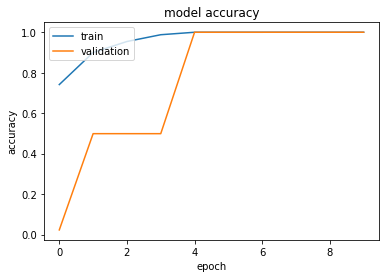

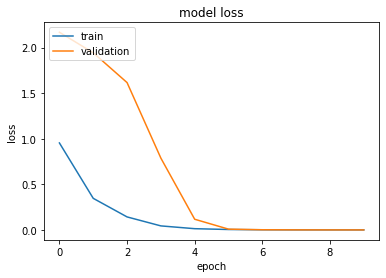

GRU
Epoch 1/10
1592/1592 - 4s - loss: 0.8554 - acc: 0.7720 - val_loss: 2.7538 - val_acc: 0.0231
Epoch 2/10
1592/1592 - 4s - loss: 0.2934 - acc: 0.9123 - val_loss: 2.0857 - val_acc: 0.4987
Epoch 3/10
1592/1592 - 4s - loss: 0.1272 - acc: 0.9564 - val_loss: 1.7781 - val_acc: 0.4987
Epoch 4/10
1592/1592 - 4s - loss: 0.0473 - acc: 0.9827 - val_loss: 1.2758 - val_acc: 0.4987
Epoch 5/10
1592/1592 - 4s - loss: 0.0169 - acc: 0.9998 - val_loss: 0.2971 - val_acc: 0.9528
Epoch 6/10
1592/1592 - 4s - loss: 0.0059 - acc: 0.9999 - val_loss: 0.0176 - val_acc: 0.9999
Epoch 7/10
1592/1592 - 4s - loss: 0.0023 - acc: 0.9999 - val_loss: 0.0028 - val_acc: 0.9999
Epoch 8/10
1592/1592 - 4s - loss: 0.0011 - acc: 0.9999 - val_loss: 9.1104e-04 - val_acc: 0.9999
Epoch 9/10
1592/1592 - 4s - loss: 7.0197e-04 - acc: 0.9999 - val_loss: 4.1620e-04 - val_acc: 0.9999
Epoch 10/10
1592/1592 - 4s - loss: 5.1531e-04 - acc: 0.9999 - val_loss: 2.6200e-04 - val_acc: 0.9999
Test Accuracy: 0.7266798719956652


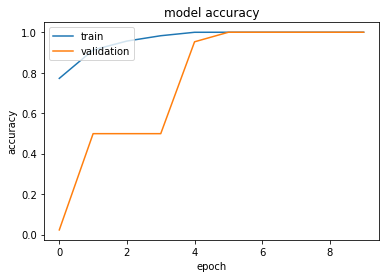

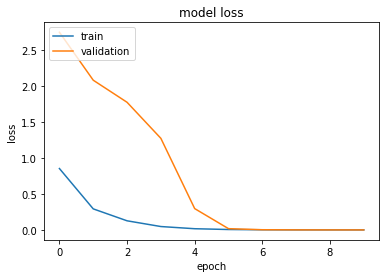

RNN
Epoch 1/10
1592/1592 - 2s - loss: 0.7204 - acc: 0.8076 - val_loss: 3.2968 - val_acc: 0.0231
Epoch 2/10
1592/1592 - 2s - loss: 0.2780 - acc: 0.9134 - val_loss: 2.2851 - val_acc: 0.4987
Epoch 3/10
1592/1592 - 2s - loss: 0.1316 - acc: 0.9555 - val_loss: 1.9701 - val_acc: 0.4987
Epoch 4/10
1592/1592 - 2s - loss: 0.0603 - acc: 0.9781 - val_loss: 1.4700 - val_acc: 0.4987
Epoch 5/10
1592/1592 - 2s - loss: 0.0256 - acc: 0.9974 - val_loss: 0.7268 - val_acc: 0.4987
Epoch 6/10
1592/1592 - 2s - loss: 0.0108 - acc: 0.9999 - val_loss: 0.0957 - val_acc: 0.9999
Epoch 7/10
1592/1592 - 2s - loss: 0.0046 - acc: 0.9999 - val_loss: 0.0102 - val_acc: 0.9999
Epoch 8/10
1592/1592 - 2s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0022 - val_acc: 0.9999
Epoch 9/10
1592/1592 - 2s - loss: 0.0011 - acc: 0.9999 - val_loss: 8.2816e-04 - val_acc: 0.9999
Epoch 10/10
1592/1592 - 2s - loss: 6.6532e-04 - acc: 0.9999 - val_loss: 4.5035e-04 - val_acc: 1.0000
Test Accuracy: 0.7266798719956652


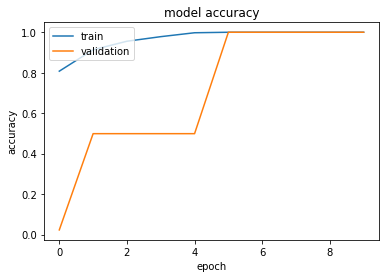

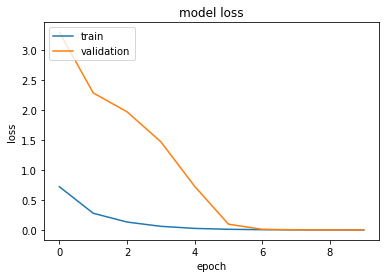

Test Accuracy: 0.9999609311207697
(219954, 1, 56) (219954, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
LSTM
Epoch 1/10
1467/1467 - 4s - loss: 1.0391 - acc: 0.7188 - val_loss: 1.0110 - val_acc: 0.5285
Epoch 2/10
1467/1467 - 3s - loss: 0.3491 - acc: 0.8958 - val_loss: 1.1077 - val_acc: 0.5285
Epoch 3/10
1467/1467 - 3s - loss: 0.1658 - acc: 0.9484 - val_loss: 1.0959 - val_acc: 0.5285
Epoch 4/10
1467/1467 - 4s - loss: 0.0580 - acc: 0.9840 - val_loss: 0.6798 - val_acc: 0.5285
Epoch 5/10
1467/1467 - 4s - loss: 0.0179 - acc: 0.9994 - val_loss: 0.1330 - val_acc: 0.9999
Epoch 6/10
1467/1467 - 5s - loss: 0.0065 - acc: 0.9999 - val_loss: 0.0157 - val_acc: 0.9999
Epoch 7/10
1467/1467 - 5s - loss: 0.0028 - acc: 0.9999 - val_loss: 0.0033 - val_acc: 0.9999
Epoch 8/10
1467/1467 - 4s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 9/10
1467/1467 - 3s - loss: 8.8330e-04 - acc: 0.9999 - val_loss: 4.7789e-04 - val_acc: 0.9999
Epoch 10/10
1467/1467 - 3s - loss: 6.354

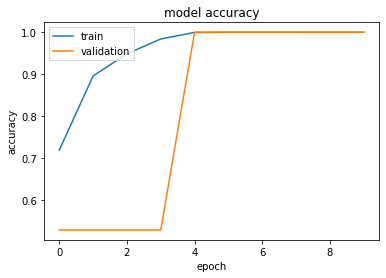

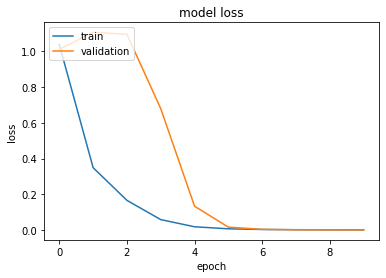

GRU
Epoch 1/10
1467/1467 - 4s - loss: 0.9134 - acc: 0.7587 - val_loss: 1.2015 - val_acc: 0.5285
Epoch 2/10
1467/1467 - 4s - loss: 0.3497 - acc: 0.8943 - val_loss: 1.2985 - val_acc: 0.5285
Epoch 3/10
1467/1467 - 3s - loss: 0.1560 - acc: 0.9487 - val_loss: 1.2271 - val_acc: 0.5285
Epoch 4/10
1467/1467 - 4s - loss: 0.0633 - acc: 0.9767 - val_loss: 0.7604 - val_acc: 0.5285
Epoch 5/10
1467/1467 - 3s - loss: 0.0224 - acc: 0.9999 - val_loss: 0.1397 - val_acc: 0.9999
Epoch 6/10
1467/1467 - 3s - loss: 0.0086 - acc: 0.9999 - val_loss: 0.0149 - val_acc: 0.9999
Epoch 7/10
1467/1467 - 3s - loss: 0.0035 - acc: 0.9999 - val_loss: 0.0027 - val_acc: 0.9999
Epoch 8/10
1467/1467 - 3s - loss: 0.0017 - acc: 0.9999 - val_loss: 8.2745e-04 - val_acc: 0.9999
Epoch 9/10
1467/1467 - 3s - loss: 9.6720e-04 - acc: 0.9999 - val_loss: 3.8134e-04 - val_acc: 0.9999
Epoch 10/10
1467/1467 - 3s - loss: 6.7140e-04 - acc: 0.9999 - val_loss: 2.2931e-04 - val_acc: 0.9999
Test Accuracy: 0.7437680479093661


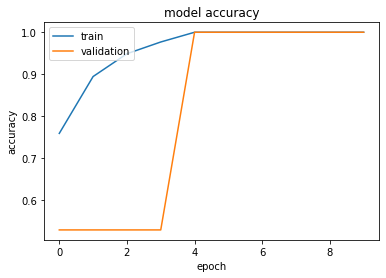

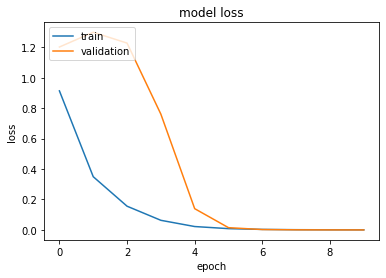

RNN
Epoch 1/10
1467/1467 - 3s - loss: 0.7141 - acc: 0.8106 - val_loss: 1.4330 - val_acc: 0.5285
Epoch 2/10
1467/1467 - 3s - loss: 0.2777 - acc: 0.9154 - val_loss: 1.4691 - val_acc: 0.5285
Epoch 3/10
1467/1467 - 3s - loss: 0.1293 - acc: 0.9579 - val_loss: 1.2301 - val_acc: 0.5285
Epoch 4/10
1467/1467 - 2s - loss: 0.0583 - acc: 0.9804 - val_loss: 0.6618 - val_acc: 0.5285
Epoch 5/10
1467/1467 - 2s - loss: 0.0238 - acc: 0.9986 - val_loss: 0.1512 - val_acc: 0.9999
Epoch 6/10
1467/1467 - 2s - loss: 0.0101 - acc: 0.9999 - val_loss: 0.0220 - val_acc: 0.9999
Epoch 7/10
1467/1467 - 2s - loss: 0.0045 - acc: 0.9999 - val_loss: 0.0040 - val_acc: 0.9999
Epoch 8/10
1467/1467 - 2s - loss: 0.0021 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 0.9999
Epoch 9/10
1467/1467 - 2s - loss: 0.0011 - acc: 0.9999 - val_loss: 5.3561e-04 - val_acc: 0.9999
Epoch 10/10
1467/1467 - 2s - loss: 7.2976e-04 - acc: 0.9999 - val_loss: 3.0890e-04 - val_acc: 1.0000
Test Accuracy: 0.7437680479093661


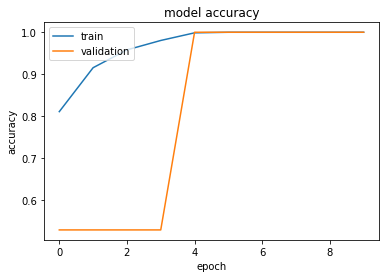

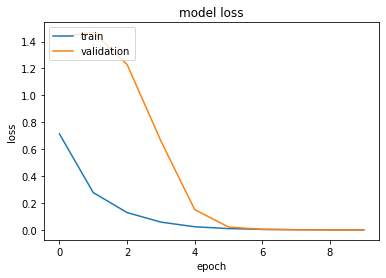

Test Accuracy: 0.9999584892408084
(201133, 1, 56) (201133, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
LSTM
Epoch 1/10
1341/1341 - 4s - loss: 1.0826 - acc: 0.7097 - val_loss: 0.8034 - val_acc: 0.7813
Epoch 2/10
1341/1341 - 3s - loss: 0.3701 - acc: 0.8856 - val_loss: 0.8467 - val_acc: 0.7813
Epoch 3/10
1341/1341 - 3s - loss: 0.1306 - acc: 0.9606 - val_loss: 0.5235 - val_acc: 0.7813
Epoch 4/10
1341/1341 - 3s - loss: 0.0451 - acc: 0.9893 - val_loss: 0.1792 - val_acc: 0.8497
Epoch 5/10
1341/1341 - 3s - loss: 0.0157 - acc: 0.9999 - val_loss: 0.0228 - val_acc: 0.9999
Epoch 6/10
1341/1341 - 4s - loss: 0.0060 - acc: 0.9999 - val_loss: 0.0055 - val_acc: 0.9999
Epoch 7/10
1341/1341 - 3s - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0021 - val_acc: 0.9999
Epoch 8/10
1341/1341 - 3s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 9/10
1341/1341 - 3s - loss: 9.3815e-04 - acc: 0.9999 - val_loss: 7.5577e-04 - val_acc: 0.9999
Epoch 10/10
1341/1341 - 3s - loss: 7.053

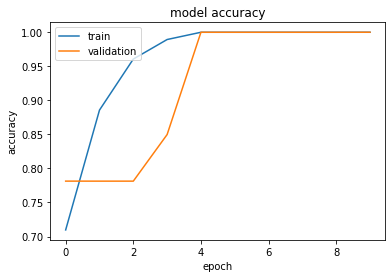

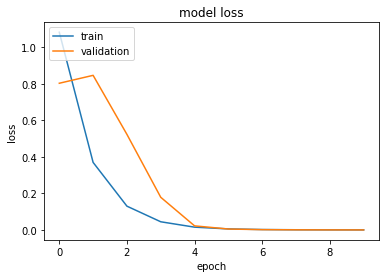

GRU
Epoch 1/10
1341/1341 - 4s - loss: 0.9796 - acc: 0.7483 - val_loss: 0.8681 - val_acc: 0.7813
Epoch 2/10
1341/1341 - 4s - loss: 0.3611 - acc: 0.8911 - val_loss: 0.8684 - val_acc: 0.7813
Epoch 3/10
1341/1341 - 3s - loss: 0.1450 - acc: 0.9558 - val_loss: 0.5818 - val_acc: 0.7813
Epoch 4/10
1341/1341 - 3s - loss: 0.0550 - acc: 0.9812 - val_loss: 0.2336 - val_acc: 0.9191
Epoch 5/10
1341/1341 - 3s - loss: 0.0208 - acc: 0.9996 - val_loss: 0.0441 - val_acc: 0.9999
Epoch 6/10
1341/1341 - 3s - loss: 0.0082 - acc: 0.9999 - val_loss: 0.0081 - val_acc: 0.9999
Epoch 7/10
1341/1341 - 3s - loss: 0.0035 - acc: 0.9999 - val_loss: 0.0027 - val_acc: 0.9999
Epoch 8/10
1341/1341 - 3s - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 0.9999
Epoch 9/10
1341/1341 - 4s - loss: 0.0010 - acc: 0.9999 - val_loss: 6.9299e-04 - val_acc: 0.9999
Epoch 10/10
1341/1341 - 3s - loss: 7.1502e-04 - acc: 0.9999 - val_loss: 5.1515e-04 - val_acc: 0.9999
Test Accuracy: 0.6585728371396605


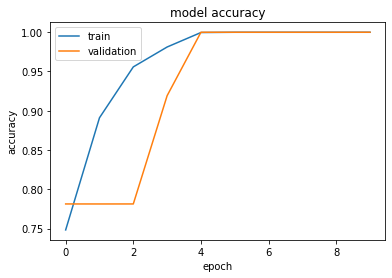

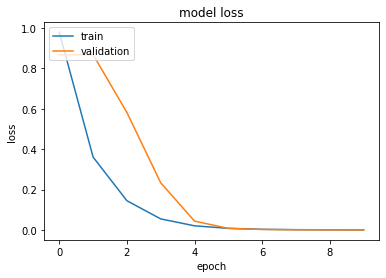

RNN
Epoch 1/10
1341/1341 - 3s - loss: 0.7840 - acc: 0.7737 - val_loss: 0.6728 - val_acc: 0.7813
Epoch 2/10
1341/1341 - 2s - loss: 0.2968 - acc: 0.9087 - val_loss: 0.6727 - val_acc: 0.7813
Epoch 3/10
1341/1341 - 2s - loss: 0.1320 - acc: 0.9598 - val_loss: 0.4035 - val_acc: 0.7819
Epoch 4/10
1341/1341 - 2s - loss: 0.0616 - acc: 0.9769 - val_loss: 0.2206 - val_acc: 0.9297
Epoch 5/10
1341/1341 - 2s - loss: 0.0289 - acc: 0.9974 - val_loss: 0.0913 - val_acc: 0.9297
Epoch 6/10
1341/1341 - 2s - loss: 0.0127 - acc: 0.9999 - val_loss: 0.0238 - val_acc: 0.9999
Epoch 7/10
1341/1341 - 2s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0062 - val_acc: 0.9999
Epoch 8/10
1341/1341 - 2s - loss: 0.0026 - acc: 0.9999 - val_loss: 0.0021 - val_acc: 0.9999
Epoch 9/10
1341/1341 - 2s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 0.9999
Epoch 10/10
1341/1341 - 2s - loss: 8.4896e-04 - acc: 0.9999 - val_loss: 6.6287e-04 - val_acc: 0.9999
Test Accuracy: 0.6585728371396605


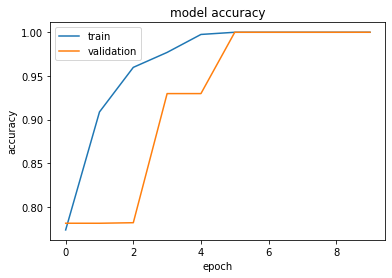

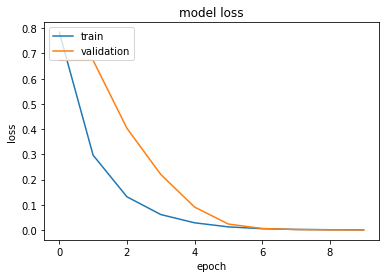

Test Accuracy: 0.9999557217661839
(182312, 1, 56) (182312, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
LSTM
Epoch 1/10
1216/1216 - 3s - loss: 1.0328 - acc: 0.7181 - val_loss: 3.3208 - val_acc: 0.1125
Epoch 2/10
1216/1216 - 3s - loss: 0.3508 - acc: 0.8936 - val_loss: 1.6520 - val_acc: 0.6310
Epoch 3/10
1216/1216 - 3s - loss: 0.1498 - acc: 0.9521 - val_loss: 1.0474 - val_acc: 0.6310
Epoch 4/10
1216/1216 - 3s - loss: 0.0534 - acc: 0.9851 - val_loss: 0.3700 - val_acc: 0.6423
Epoch 5/10
1216/1216 - 3s - loss: 0.0188 - acc: 0.9999 - val_loss: 0.0554 - val_acc: 0.9999
Epoch 6/10
1216/1216 - 3s - loss: 0.0076 - acc: 0.9999 - val_loss: 0.0093 - val_acc: 0.9999
Epoch 7/10
1216/1216 - 3s - loss: 0.0036 - acc: 0.9999 - val_loss: 0.0032 - val_acc: 0.9999
Epoch 8/10
1216/1216 - 3s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 9/10
1216/1216 - 3s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9999
Epoch 10/10
1216/1216 - 3s - loss: 8.3209e-04 - 

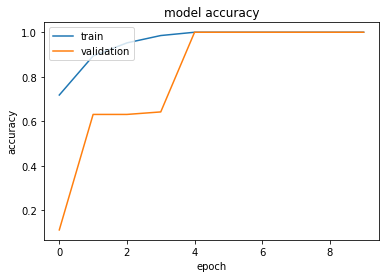

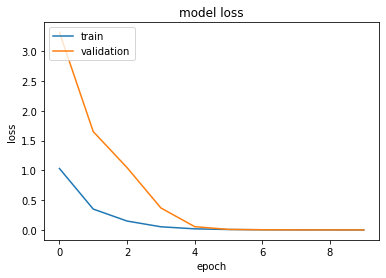

GRU
Epoch 1/10
1216/1216 - 3s - loss: 1.0208 - acc: 0.7292 - val_loss: 2.9812 - val_acc: 0.1125
Epoch 2/10
1216/1216 - 3s - loss: 0.3797 - acc: 0.8827 - val_loss: 1.4556 - val_acc: 0.6310
Epoch 3/10
1216/1216 - 3s - loss: 0.1539 - acc: 0.9489 - val_loss: 0.8461 - val_acc: 0.6310
Epoch 4/10
1216/1216 - 3s - loss: 0.0628 - acc: 0.9786 - val_loss: 0.4327 - val_acc: 0.8544
Epoch 5/10
1216/1216 - 3s - loss: 0.0264 - acc: 0.9999 - val_loss: 0.1923 - val_acc: 0.8632
Epoch 6/10
1216/1216 - 3s - loss: 0.0118 - acc: 0.9999 - val_loss: 0.0600 - val_acc: 0.9999
Epoch 7/10
1216/1216 - 3s - loss: 0.0054 - acc: 0.9999 - val_loss: 0.0148 - val_acc: 0.9999
Epoch 8/10
1216/1216 - 3s - loss: 0.0026 - acc: 0.9999 - val_loss: 0.0041 - val_acc: 0.9999
Epoch 9/10
1216/1216 - 3s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9999
Epoch 10/10
1216/1216 - 3s - loss: 9.4468e-04 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 0.9999
Test Accuracy: 0.6844174696245506


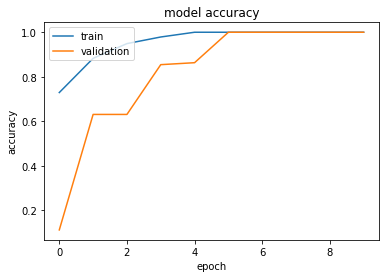

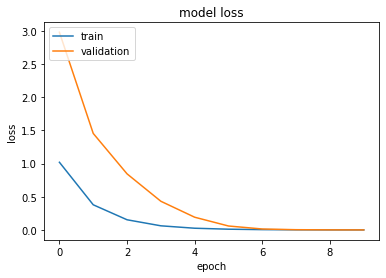

RNN
Epoch 1/10
1216/1216 - 2s - loss: 0.8416 - acc: 0.7695 - val_loss: 3.0408 - val_acc: 0.1125
Epoch 2/10
1216/1216 - 2s - loss: 0.3135 - acc: 0.8957 - val_loss: 1.5743 - val_acc: 0.6310
Epoch 3/10
1216/1216 - 2s - loss: 0.1404 - acc: 0.9535 - val_loss: 0.9587 - val_acc: 0.6310
Epoch 4/10
1216/1216 - 2s - loss: 0.0633 - acc: 0.9809 - val_loss: 0.4679 - val_acc: 0.6896
Epoch 5/10
1216/1216 - 2s - loss: 0.0272 - acc: 0.9999 - val_loss: 0.1206 - val_acc: 0.9998
Epoch 6/10
1216/1216 - 2s - loss: 0.0120 - acc: 0.9999 - val_loss: 0.0212 - val_acc: 0.9999
Epoch 7/10
1216/1216 - 2s - loss: 0.0055 - acc: 0.9999 - val_loss: 0.0056 - val_acc: 0.9999
Epoch 8/10
1216/1216 - 2s - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0023 - val_acc: 0.9999
Epoch 9/10
1216/1216 - 2s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0013 - val_acc: 0.9999
Epoch 10/10
1216/1216 - 2s - loss: 9.8765e-04 - acc: 0.9999 - val_loss: 9.2887e-04 - val_acc: 0.9999
Test Accuracy: 0.6844174696245506


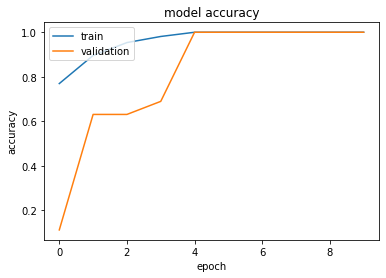

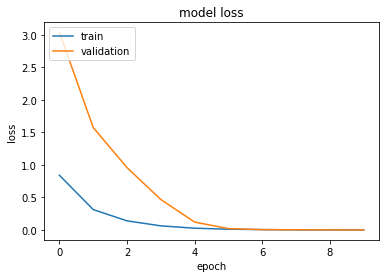

Test Accuracy: 0.9999525589241615
(163491, 1, 56) (163491, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
LSTM
Epoch 1/10
1090/1090 - 3s - loss: 1.2608 - acc: 0.6665 - val_loss: 1.7529 - val_acc: 0.0000e+00
Epoch 2/10
1090/1090 - 3s - loss: 0.4977 - acc: 0.8511 - val_loss: 1.4127 - val_acc: 0.5989
Epoch 3/10
1090/1090 - 3s - loss: 0.2098 - acc: 0.9342 - val_loss: 0.8334 - val_acc: 0.5989
Epoch 4/10
1090/1090 - 3s - loss: 0.0797 - acc: 0.9759 - val_loss: 0.2844 - val_acc: 0.8727
Epoch 5/10
1090/1090 - 4s - loss: 0.0283 - acc: 0.9999 - val_loss: 0.0345 - val_acc: 0.9998
Epoch 6/10
1090/1090 - 3s - loss: 0.0121 - acc: 0.9999 - val_loss: 0.0069 - val_acc: 0.9998
Epoch 7/10
1090/1090 - 3s - loss: 0.0058 - acc: 0.9999 - val_loss: 0.0030 - val_acc: 0.9998
Epoch 8/10
1090/1090 - 2s - loss: 0.0030 - acc: 0.9999 - val_loss: 0.0018 - val_acc: 0.9998
Epoch 9/10
1090/1090 - 2s - loss: 0.0018 - acc: 0.9999 - val_loss: 0.0013 - val_acc: 0.9998
Epoch 10/10
1090/1090 - 2s - loss: 0.0012 - 

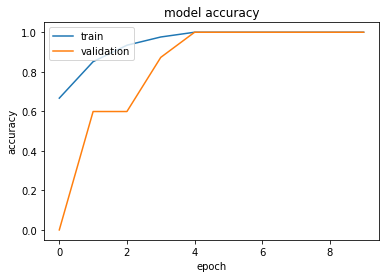

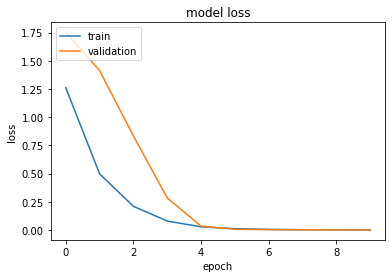

GRU
Epoch 1/10
1090/1090 - 3s - loss: 1.1562 - acc: 0.6840 - val_loss: 0.8028 - val_acc: 0.5989
Epoch 2/10
1090/1090 - 3s - loss: 0.5031 - acc: 0.8398 - val_loss: 1.0476 - val_acc: 0.5989
Epoch 3/10
1090/1090 - 3s - loss: 0.2096 - acc: 0.9269 - val_loss: 0.8617 - val_acc: 0.5989
Epoch 4/10
1090/1090 - 3s - loss: 0.0793 - acc: 0.9738 - val_loss: 0.4271 - val_acc: 0.6229
Epoch 5/10
1090/1090 - 3s - loss: 0.0294 - acc: 0.9985 - val_loss: 0.1201 - val_acc: 0.9998
Epoch 6/10
1090/1090 - 3s - loss: 0.0125 - acc: 0.9999 - val_loss: 0.0261 - val_acc: 0.9998
Epoch 7/10
1090/1090 - 3s - loss: 0.0059 - acc: 0.9999 - val_loss: 0.0076 - val_acc: 0.9998
Epoch 8/10
1090/1090 - 3s - loss: 0.0030 - acc: 0.9999 - val_loss: 0.0032 - val_acc: 0.9998
Epoch 9/10
1090/1090 - 3s - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9998
Epoch 10/10
1090/1090 - 3s - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 0.9998
Test Accuracy: 0.7102624354931967


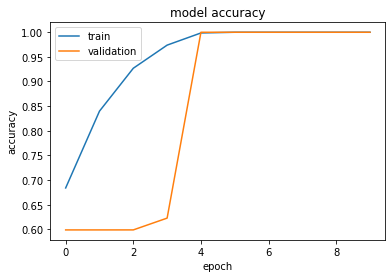

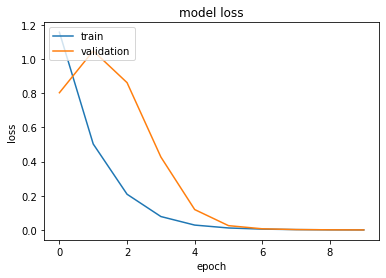

RNN
Epoch 1/10
1090/1090 - 2s - loss: 0.9261 - acc: 0.7520 - val_loss: 2.7813 - val_acc: 0.0000e+00
Epoch 2/10
1090/1090 - 2s - loss: 0.3504 - acc: 0.8903 - val_loss: 1.4580 - val_acc: 0.5989
Epoch 3/10
1090/1090 - 2s - loss: 0.1649 - acc: 0.9468 - val_loss: 0.8758 - val_acc: 0.5989
Epoch 4/10
1090/1090 - 2s - loss: 0.0820 - acc: 0.9763 - val_loss: 0.3336 - val_acc: 0.6830
Epoch 5/10
1090/1090 - 2s - loss: 0.0390 - acc: 0.9948 - val_loss: 0.0627 - val_acc: 0.9999
Epoch 6/10
1090/1090 - 2s - loss: 0.0185 - acc: 0.9999 - val_loss: 0.0133 - val_acc: 0.9998
Epoch 7/10
1090/1090 - 2s - loss: 0.0087 - acc: 0.9999 - val_loss: 0.0046 - val_acc: 0.9998
Epoch 8/10
1090/1090 - 2s - loss: 0.0043 - acc: 0.9999 - val_loss: 0.0022 - val_acc: 0.9998
Epoch 9/10
1090/1090 - 2s - loss: 0.0023 - acc: 0.9999 - val_loss: 0.0014 - val_acc: 0.9998
Epoch 10/10
1090/1090 - 2s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 0.9998
Test Accuracy: 0.7102624354931967


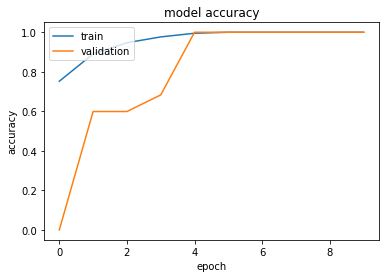

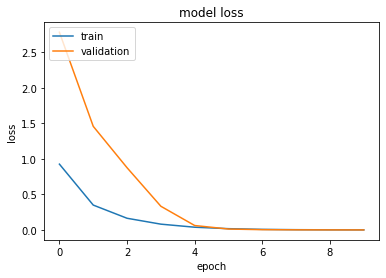

Test Accuracy: 0.9999489096814799
(144671, 1, 56) (144671, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
LSTM
Epoch 1/10
965/965 - 4s - loss: 1.2964 - acc: 0.6477 - val_loss: 0.7821 - val_acc: 0.4985
Epoch 2/10
965/965 - 3s - loss: 0.4612 - acc: 0.8535 - val_loss: 0.3191 - val_acc: 0.7398
Epoch 3/10
965/965 - 3s - loss: 0.2011 - acc: 0.9355 - val_loss: 0.0568 - val_acc: 0.9998
Epoch 4/10
965/965 - 2s - loss: 0.0811 - acc: 0.9779 - val_loss: 0.0128 - val_acc: 0.9998
Epoch 5/10
965/965 - 2s - loss: 0.0320 - acc: 0.9987 - val_loss: 0.0061 - val_acc: 0.9998
Epoch 6/10
965/965 - 2s - loss: 0.0148 - acc: 0.9999 - val_loss: 0.0037 - val_acc: 0.9998
Epoch 7/10
965/965 - 2s - loss: 0.0075 - acc: 0.9999 - val_loss: 0.0025 - val_acc: 0.9998
Epoch 8/10
965/965 - 3s - loss: 0.0040 - acc: 0.9999 - val_loss: 0.0018 - val_acc: 0.9998
Epoch 9/10
965/965 - 3s - loss: 0.0023 - acc: 0.9999 - val_loss: 0.0014 - val_acc: 0.9998
Epoch 10/10
965/965 - 2s - loss: 0.0015 - acc: 0.9999 - val_loss: 

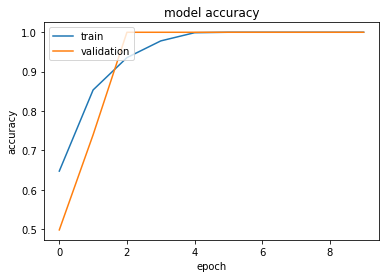

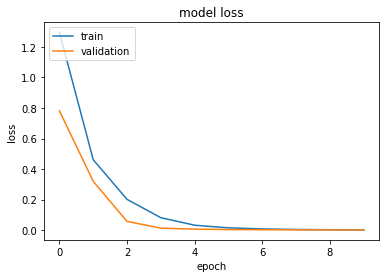

GRU
Epoch 1/10
965/965 - 3s - loss: 1.1289 - acc: 0.6793 - val_loss: 0.6620 - val_acc: 0.6937
Epoch 2/10
965/965 - 2s - loss: 0.4354 - acc: 0.8588 - val_loss: 0.2977 - val_acc: 0.7398
Epoch 3/10
965/965 - 2s - loss: 0.1615 - acc: 0.9480 - val_loss: 0.0275 - val_acc: 0.9998
Epoch 4/10
965/965 - 2s - loss: 0.0653 - acc: 0.9782 - val_loss: 0.0070 - val_acc: 0.9998
Epoch 5/10
965/965 - 2s - loss: 0.0282 - acc: 0.9999 - val_loss: 0.0035 - val_acc: 0.9998
Epoch 6/10
965/965 - 2s - loss: 0.0129 - acc: 0.9999 - val_loss: 0.0022 - val_acc: 0.9998
Epoch 7/10
965/965 - 2s - loss: 0.0062 - acc: 0.9999 - val_loss: 0.0016 - val_acc: 0.9998
Epoch 8/10
965/965 - 2s - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0013 - val_acc: 0.9998
Epoch 9/10
965/965 - 2s - loss: 0.0018 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9998
Epoch 10/10
965/965 - 2s - loss: 0.0012 - acc: 0.9999 - val_loss: 9.0456e-04 - val_acc: 0.9998
Test Accuracy: 0.6370742785293064


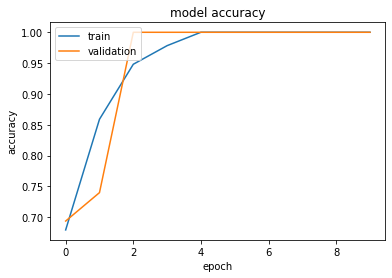

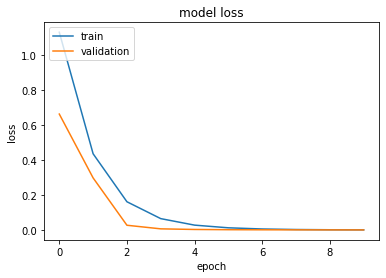

RNN
Epoch 1/10
965/965 - 2s - loss: 1.0227 - acc: 0.7087 - val_loss: 0.5921 - val_acc: 0.7264
Epoch 2/10
965/965 - 2s - loss: 0.4071 - acc: 0.8731 - val_loss: 0.2013 - val_acc: 0.9469
Epoch 3/10
965/965 - 2s - loss: 0.1862 - acc: 0.9446 - val_loss: 0.0410 - val_acc: 0.9998
Epoch 4/10
965/965 - 1s - loss: 0.0810 - acc: 0.9739 - val_loss: 0.0125 - val_acc: 0.9998
Epoch 5/10
965/965 - 1s - loss: 0.0372 - acc: 0.9999 - val_loss: 0.0060 - val_acc: 0.9998
Epoch 6/10
965/965 - 1s - loss: 0.0177 - acc: 0.9999 - val_loss: 0.0034 - val_acc: 0.9998
Epoch 7/10
965/965 - 2s - loss: 0.0087 - acc: 0.9999 - val_loss: 0.0023 - val_acc: 0.9998
Epoch 8/10
965/965 - 2s - loss: 0.0045 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9998
Epoch 9/10
965/965 - 1s - loss: 0.0025 - acc: 0.9999 - val_loss: 0.0013 - val_acc: 0.9998
Epoch 10/10
965/965 - 2s - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 0.9998
Test Accuracy: 0.6370742785293064


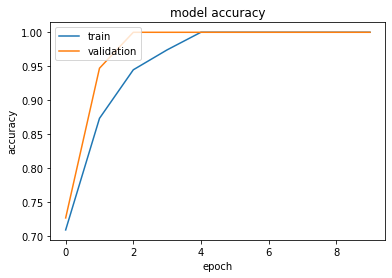

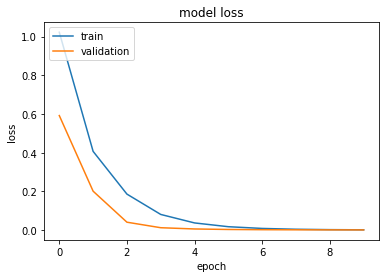

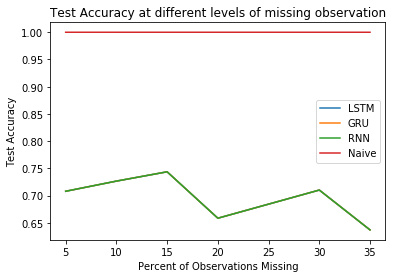

In [662]:
lst = range(5,40, 5)
test_acc_lstm = list()
test_acc_gru = list()
test_acc_simple = list()
test_acc_naive = list()

for i in lst:
    dataset = copy.copy()
    dataset = drop(i/100, dataset)
    
    test_acc_naive.append(naive(dataset))
    
    train_X, train_y, val_X, val_y, test_X, test_y  = preprocess(dataset)
    print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    print("LSTM")
    accuracy_lstm = lstm(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_lstm.append(accuracy_lstm)
    
    print("GRU")
    accuracy_gru = gru(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_gru.append(accuracy_gru)
    
    print("RNN")
    accuracy_simple = simpleRNN(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_simple.append(accuracy_simple)
    
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.plot(lst,test_acc_naive)
pyplot.title('Test Accuracy at different levels of missing observation')
pyplot.ylabel('Test Accuracy')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN', 'Naive'], loc='best')
pyplot.show()

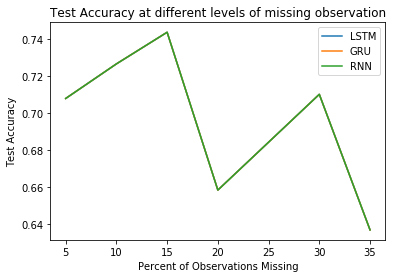

In [663]:
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.title('Test Accuracy at different levels of missing observation')
pyplot.ylabel('Test Accuracy')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN'], loc='best')
pyplot.show()

In [704]:
print(test_acc_lstm)
print(test_acc_gru)
print(test_acc_simple)

[0.7080125833499135, 0.7266798719956652, 0.7437680479093661, 0.6585728371396605, 0.6844174696245506, 0.7102624354931967, 0.6370742785293064]
[0.7080125833499135, 0.7266798719956652, 0.7437680479093661, 0.6585728371396605, 0.6844174696245506, 0.7102624354931967, 0.6370742785293064]
[0.7080125833499135, 0.7266798719956652, 0.7437680479093661, 0.6585728371396605, 0.6844174696245506, 0.7102624354931967, 0.6370742785293064]


# Experiment 2

In [584]:
lst = range(5,40, 5)
test_acc_lstm = list()
test_acc_gru = list()
test_acc_simple = list()

for i in lst:
    dataset = copy.copy()
    dataset = notanumber(i/100, dataset)
    dataset.loc[:,:] = dataset.loc[:,:].ffill()
    train_X, train_y, val_X, val_y, test_X, test_y  = preprocess(dataset)
    print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    accuracy_lstm = lstm(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_lstm.append(accuracy_lstm)
    
    accuracy_gru = gru(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_gru.append(accuracy_gru)
    
    accuracy_simple = simpleRNN(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_simple.append(accuracy_simple)
    
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.title('Test Accuracy at different levels of missing observation')
pyplot.ylabel('Test Accuracy')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN'], loc='best')
pyplot.show()

[366441, 11517578, 6380210, 15009034]


KeyboardInterrupt: 

# Experiment 3

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 6s - loss: 0.8782 - acc: 0.7707 - val_loss: 1.7512 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 5s - loss: 0.3192 - acc: 0.9123 - val_loss: 2.2997 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 4s - loss: 0.1350 - acc: 0.9615 - val_loss: 2.3218 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 4s - loss: 0.0445 - acc: 0.9847 - val_loss: 1.9362 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 5s - loss: 0.0140 - acc: 0.9988 - val_loss: 0.7860 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 4s - loss: 0.0046 - acc: 0.9999 - val_loss: 0.0226 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 5s - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0023 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 5s - loss: 8.3154e-04 - acc: 0.9999 - val_loss: 6.9708e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 6s - loss: 5.5634e-04 - acc: 0.9999 - val_loss: 3.4513e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 6s - loss: 4.3970e-04 - acc: 0.9999 - val_loss:

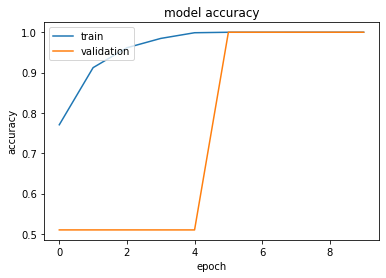

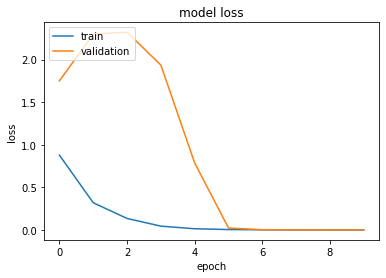

Epoch 1/10
1843/1843 - 7s - loss: 0.7333 - acc: 0.8048 - val_loss: 1.8062 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 5s - loss: 0.2371 - acc: 0.9275 - val_loss: 2.4714 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 5s - loss: 0.1023 - acc: 0.9664 - val_loss: 2.1243 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 5s - loss: 0.0408 - acc: 0.9852 - val_loss: 1.8114 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 5s - loss: 0.0138 - acc: 0.9988 - val_loss: 1.3157 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 5s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.4505 - val_acc: 0.5331
Epoch 7/10
1843/1843 - 5s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0279 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 5s - loss: 9.5081e-04 - acc: 0.9999 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 5s - loss: 5.6856e-04 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 4s - loss: 4.0723e-04 - acc: 0.9999 - val_loss: 3.4435e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


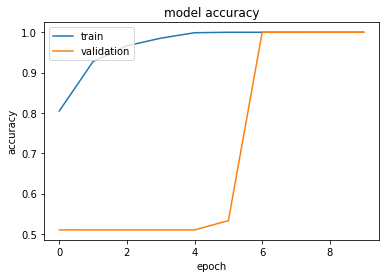

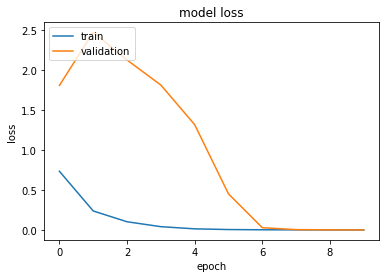

Epoch 1/10
1843/1843 - 3s - loss: 0.6265 - acc: 0.8323 - val_loss: 1.9924 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 4s - loss: 0.2445 - acc: 0.9288 - val_loss: 2.4395 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1218 - acc: 0.9626 - val_loss: 2.2215 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0528 - acc: 0.9806 - val_loss: 1.8591 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0207 - acc: 0.9965 - val_loss: 1.2110 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0082 - acc: 0.9999 - val_loss: 0.3037 - val_acc: 0.8983
Epoch 7/10
1843/1843 - 3s - loss: 0.0031 - acc: 0.9999 - val_loss: 0.0329 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 4s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 6.9682e-04 - acc: 0.9999 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.4540e-04 - acc: 0.9999 - val_loss: 4.9568e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


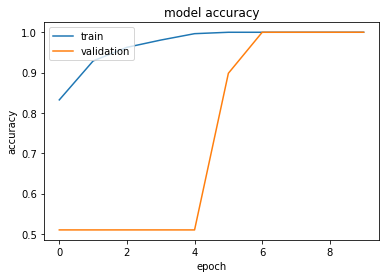

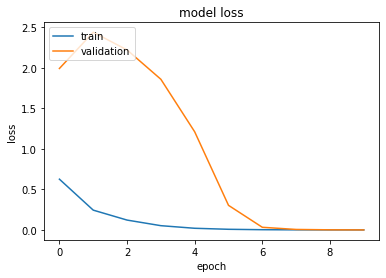

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 5s - loss: 0.8952 - acc: 0.7643 - val_loss: 1.7282 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 5s - loss: 0.2618 - acc: 0.9237 - val_loss: 2.4011 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 4s - loss: 0.1318 - acc: 0.9617 - val_loss: 2.1560 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 4s - loss: 0.0456 - acc: 0.9840 - val_loss: 1.6605 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 5s - loss: 0.0150 - acc: 0.9984 - val_loss: 0.5506 - val_acc: 0.5128
Epoch 6/10
1843/1843 - 6s - loss: 0.0048 - acc: 0.9999 - val_loss: 0.0280 - val_acc: 1.0000
Epoch 7/10
1843/1843 - 4s - loss: 0.0018 - acc: 0.9999 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 5s - loss: 8.8978e-04 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 5s - loss: 5.5948e-04 - acc: 0.9999 - val_loss: 4.2261e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 6s - loss: 4.1835e-04 - acc: 0.9999 - val_loss: 2.0

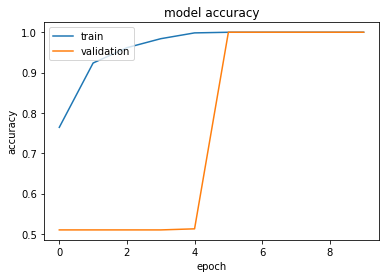

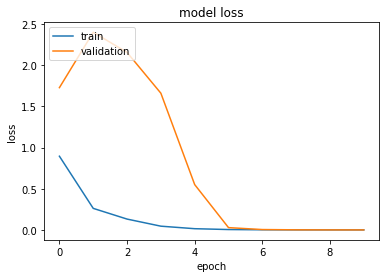

Epoch 1/10
1843/1843 - 6s - loss: 0.7663 - acc: 0.7987 - val_loss: 1.5904 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 7s - loss: 0.2624 - acc: 0.9226 - val_loss: 2.2659 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 6s - loss: 0.1107 - acc: 0.9648 - val_loss: 1.7767 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 7s - loss: 0.0449 - acc: 0.9838 - val_loss: 1.0829 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 5s - loss: 0.0153 - acc: 0.9977 - val_loss: 0.2218 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 5s - loss: 0.0051 - acc: 0.9999 - val_loss: 0.0109 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 4s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0015 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 4s - loss: 8.5630e-04 - acc: 0.9999 - val_loss: 5.2622e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 4s - loss: 5.2267e-04 - acc: 0.9999 - val_loss: 2.5280e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 4s - loss: 3.8302e-04 - acc: 0.9999 - val_loss: 1.6462e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


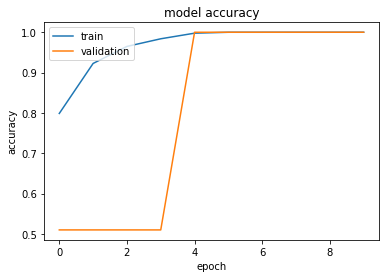

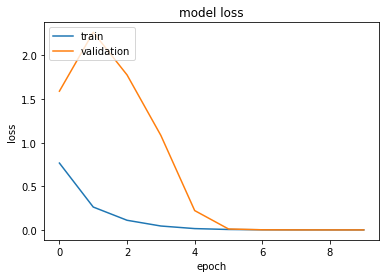

Epoch 1/10
1843/1843 - 3s - loss: 0.6710 - acc: 0.8267 - val_loss: 1.9136 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2546 - acc: 0.9301 - val_loss: 2.3126 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1222 - acc: 0.9604 - val_loss: 2.0929 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0522 - acc: 0.9813 - val_loss: 1.7430 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0214 - acc: 0.9977 - val_loss: 1.0400 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 4s - loss: 0.0086 - acc: 0.9996 - val_loss: 0.1240 - val_acc: 1.0000
Epoch 7/10
1843/1843 - 5s - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0079 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 3s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 5s - loss: 6.8876e-04 - acc: 1.0000 - val_loss: 5.0149e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.5016e-04 - acc: 0.9999 - val_loss: 1.8489e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


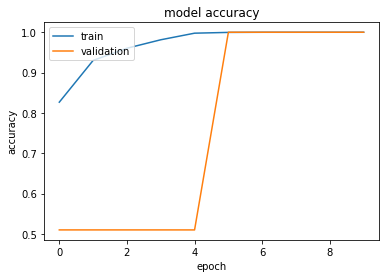

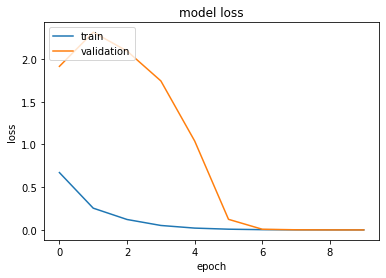

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 5s - loss: 0.8644 - acc: 0.7797 - val_loss: 1.6146 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 4s - loss: 0.2566 - acc: 0.9252 - val_loss: 2.1696 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 4s - loss: 0.1274 - acc: 0.9568 - val_loss: 1.7794 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 4s - loss: 0.0396 - acc: 0.9874 - val_loss: 0.9551 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 4s - loss: 0.0118 - acc: 0.9999 - val_loss: 0.1017 - val_acc: 1.0000
Epoch 6/10
1843/1843 - 4s - loss: 0.0039 - acc: 0.9999 - val_loss: 0.0113 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 4s - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0026 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 4s - loss: 8.3216e-04 - acc: 0.9999 - val_loss: 8.4439e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 4s - loss: 5.6042e-04 - acc: 0.9999 - val_loss: 3.9184e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 4s - loss: 4.3928e-04 - acc: 0.9999 - val_loss:

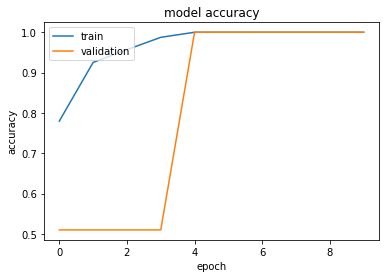

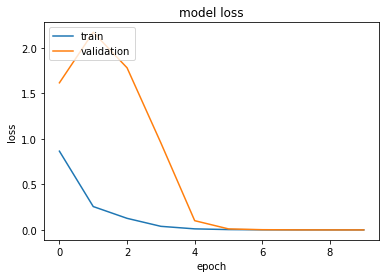

Epoch 1/10
1843/1843 - 5s - loss: 0.7982 - acc: 0.7883 - val_loss: 1.6361 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 4s - loss: 0.2429 - acc: 0.9275 - val_loss: 2.1432 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 4s - loss: 0.1131 - acc: 0.9625 - val_loss: 1.8437 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 4s - loss: 0.0435 - acc: 0.9845 - val_loss: 1.6577 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 4s - loss: 0.0142 - acc: 0.9980 - val_loss: 1.1125 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 4s - loss: 0.0049 - acc: 0.9999 - val_loss: 0.3283 - val_acc: 0.8445
Epoch 7/10
1843/1843 - 4s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0136 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 4s - loss: 9.1188e-04 - acc: 0.9999 - val_loss: 0.0017 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 4s - loss: 5.6724e-04 - acc: 0.9999 - val_loss: 5.0913e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 4s - loss: 4.2851e-04 - acc: 0.9999 - val_loss: 2.3691e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


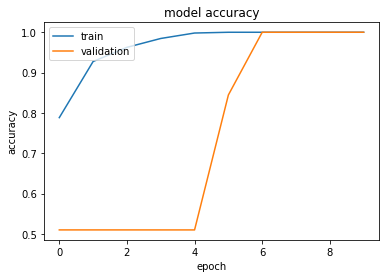

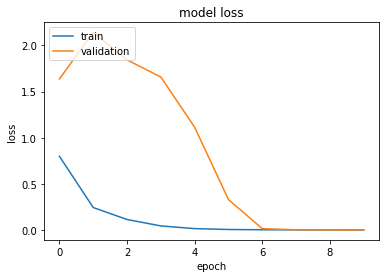

Epoch 1/10
1843/1843 - 3s - loss: 0.6366 - acc: 0.8350 - val_loss: 1.8170 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2274 - acc: 0.9296 - val_loss: 2.3024 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1177 - acc: 0.9603 - val_loss: 2.0337 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0538 - acc: 0.9815 - val_loss: 1.6419 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0217 - acc: 0.9948 - val_loss: 0.8760 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0086 - acc: 0.9999 - val_loss: 0.1073 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0035 - acc: 0.9999 - val_loss: 0.0112 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0020 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 7.1197e-04 - acc: 0.9999 - val_loss: 5.9676e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.5428e-04 - acc: 0.9999 - val_loss: 2.5099e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


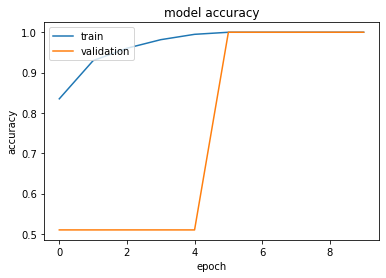

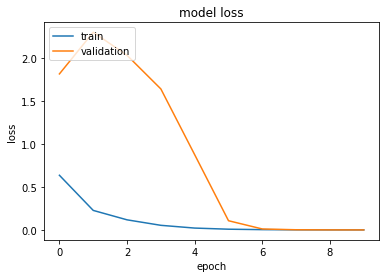

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 7s - loss: 0.7939 - acc: 0.7882 - val_loss: 1.6291 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 5s - loss: 0.2755 - acc: 0.9185 - val_loss: 2.1619 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 5s - loss: 0.1074 - acc: 0.9644 - val_loss: 2.0183 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 5s - loss: 0.0281 - acc: 0.9929 - val_loss: 1.0710 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 4s - loss: 0.0091 - acc: 0.9999 - val_loss: 0.1225 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 4s - loss: 0.0033 - acc: 0.9999 - val_loss: 0.0116 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 5s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0022 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 5s - loss: 7.5837e-04 - acc: 0.9999 - val_loss: 6.5900e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 4s - loss: 5.2007e-04 - acc: 0.9999 - val_loss: 2.9732e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 5s - loss: 3.9127e-04 - acc: 0.9999 - val_loss:

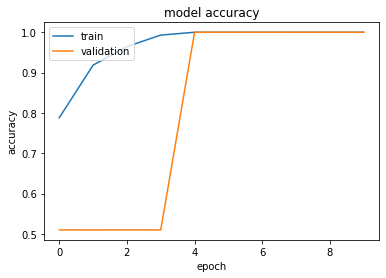

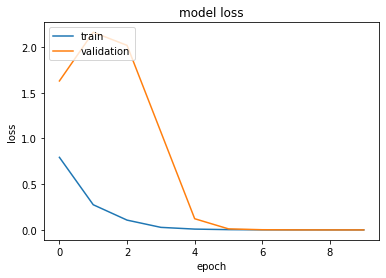

Epoch 1/10
1843/1843 - 6s - loss: 0.8174 - acc: 0.7835 - val_loss: 1.7202 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 5s - loss: 0.2967 - acc: 0.9153 - val_loss: 2.1075 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 5s - loss: 0.1208 - acc: 0.9611 - val_loss: 1.8951 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 5s - loss: 0.0431 - acc: 0.9834 - val_loss: 1.5974 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 5s - loss: 0.0136 - acc: 0.9993 - val_loss: 0.7124 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 5s - loss: 0.0045 - acc: 0.9999 - val_loss: 0.0293 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 4s - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 5s - loss: 8.0203e-04 - acc: 0.9999 - val_loss: 8.1754e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 5s - loss: 5.0498e-04 - acc: 0.9999 - val_loss: 2.9804e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 5s - loss: 3.7884e-04 - acc: 0.9999 - val_loss: 1.7456e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


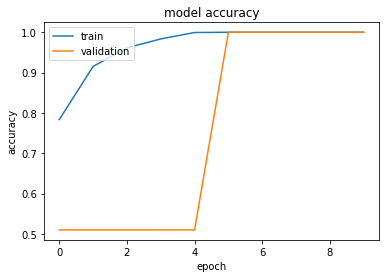

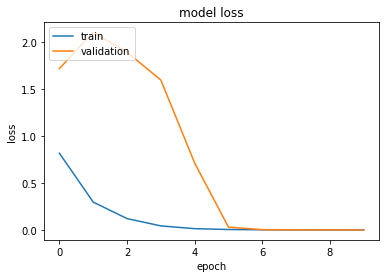

Epoch 1/10
1843/1843 - 4s - loss: 0.6923 - acc: 0.8171 - val_loss: 1.7710 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2502 - acc: 0.9257 - val_loss: 2.0324 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1197 - acc: 0.9611 - val_loss: 1.9345 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0560 - acc: 0.9799 - val_loss: 1.4623 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0218 - acc: 0.9952 - val_loss: 0.4860 - val_acc: 0.5128
Epoch 6/10
1843/1843 - 3s - loss: 0.0076 - acc: 0.9999 - val_loss: 0.0348 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0028 - acc: 0.9999 - val_loss: 0.0047 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 6.5828e-04 - acc: 0.9999 - val_loss: 4.2489e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 4.5865e-04 - acc: 0.9999 - val_loss: 2.3263e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


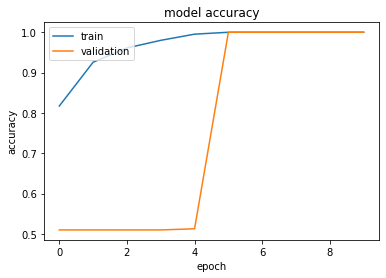

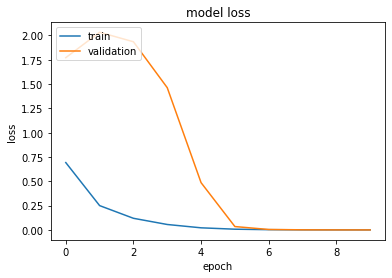

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 8s - loss: 0.9000 - acc: 0.7669 - val_loss: 1.9449 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 4s - loss: 0.3151 - acc: 0.9123 - val_loss: 1.9450 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 6s - loss: 0.1178 - acc: 0.9638 - val_loss: 1.7713 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 5s - loss: 0.0400 - acc: 0.9862 - val_loss: 1.1886 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 4s - loss: 0.0118 - acc: 0.9999 - val_loss: 0.2170 - val_acc: 0.9977
Epoch 6/10
1843/1843 - 4s - loss: 0.0039 - acc: 0.9999 - val_loss: 0.0245 - val_acc: 1.0000
Epoch 7/10
1843/1843 - 5s - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0044 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 6s - loss: 7.9925e-04 - acc: 0.9999 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 5s - loss: 5.2676e-04 - acc: 0.9999 - val_loss: 4.0158e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 5s - loss: 3.9614e-04 - acc: 0.9999 - val_loss: 1.9

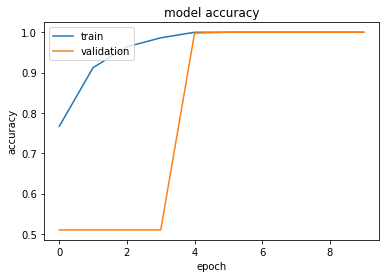

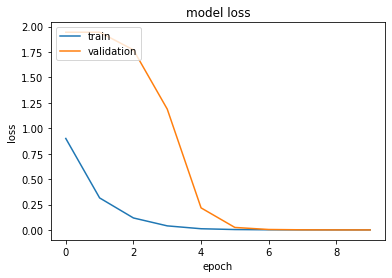

Epoch 1/10
1843/1843 - 14s - loss: 0.7924 - acc: 0.7898 - val_loss: 1.9711 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 6s - loss: 0.2985 - acc: 0.9135 - val_loss: 2.1778 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 6s - loss: 0.1291 - acc: 0.9589 - val_loss: 1.8173 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 5s - loss: 0.0434 - acc: 0.9844 - val_loss: 1.0717 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 6s - loss: 0.0127 - acc: 0.9999 - val_loss: 0.2351 - val_acc: 0.9762
Epoch 6/10
1843/1843 - 7s - loss: 0.0041 - acc: 0.9999 - val_loss: 0.0236 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 7s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0034 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 5s - loss: 7.8300e-04 - acc: 0.9999 - val_loss: 8.8551e-04 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 5s - loss: 5.3852e-04 - acc: 0.9999 - val_loss: 3.6921e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 7s - loss: 4.3128e-04 - acc: 0.9999 - val_loss: 2.6100e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


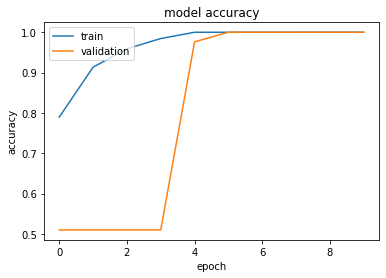

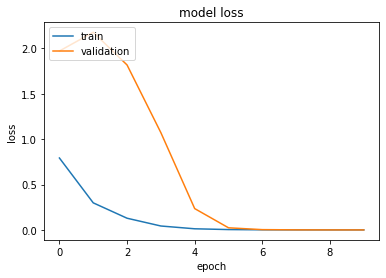

Epoch 1/10
1843/1843 - 3s - loss: 0.7063 - acc: 0.8137 - val_loss: 1.6041 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2460 - acc: 0.9276 - val_loss: 2.2068 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1244 - acc: 0.9591 - val_loss: 2.1956 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 4s - loss: 0.0625 - acc: 0.9782 - val_loss: 1.8647 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0267 - acc: 0.9939 - val_loss: 1.3505 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0098 - acc: 0.9999 - val_loss: 0.2804 - val_acc: 0.9832
Epoch 7/10
1843/1843 - 4s - loss: 0.0037 - acc: 0.9999 - val_loss: 0.0189 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 4s - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0035 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 7.9364e-04 - acc: 0.9999 - val_loss: 9.2170e-04 - val_acc: 0.9999
Epoch 10/10
1843/1843 - 4s - loss: 4.8178e-04 - acc: 0.9999 - val_loss: 3.1857e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


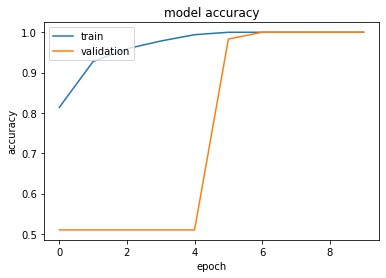

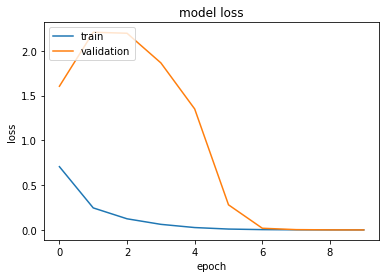

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 5s - loss: 0.8854 - acc: 0.7643 - val_loss: 1.9133 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 5s - loss: 0.2868 - acc: 0.9192 - val_loss: 2.2312 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 5s - loss: 0.1364 - acc: 0.9594 - val_loss: 1.9994 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 5s - loss: 0.0458 - acc: 0.9843 - val_loss: 1.2544 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 6s - loss: 0.0114 - acc: 0.9999 - val_loss: 0.1459 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 5s - loss: 0.0032 - acc: 0.9999 - val_loss: 0.0132 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 5s - loss: 0.0013 - acc: 0.9999 - val_loss: 0.0034 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 5s - loss: 7.2503e-04 - acc: 0.9999 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 5s - loss: 5.2119e-04 - acc: 0.9999 - val_loss: 4.2494e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 5s - loss: 4.1431e-04 - acc: 0.9999 - val_loss: 2.6

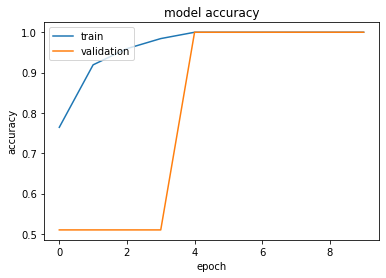

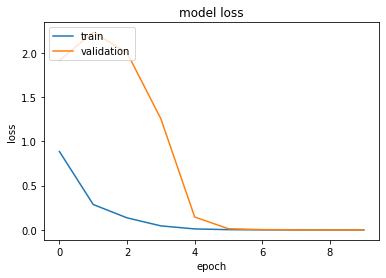

Epoch 1/10
1843/1843 - 5s - loss: 0.7422 - acc: 0.8026 - val_loss: 1.8101 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 6s - loss: 0.3005 - acc: 0.9124 - val_loss: 2.3232 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 6s - loss: 0.1298 - acc: 0.9599 - val_loss: 1.9315 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 6s - loss: 0.0432 - acc: 0.9835 - val_loss: 0.9014 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 5s - loss: 0.0128 - acc: 0.9999 - val_loss: 0.0863 - val_acc: 0.9999
Epoch 6/10
1843/1843 - 4s - loss: 0.0043 - acc: 0.9999 - val_loss: 0.0153 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 5s - loss: 0.0017 - acc: 0.9999 - val_loss: 0.0034 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 5s - loss: 8.1966e-04 - acc: 0.9999 - val_loss: 9.3266e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 5s - loss: 5.1780e-04 - acc: 0.9999 - val_loss: 3.3960e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 5s - loss: 3.8035e-04 - acc: 0.9999 - val_loss: 1.9710e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


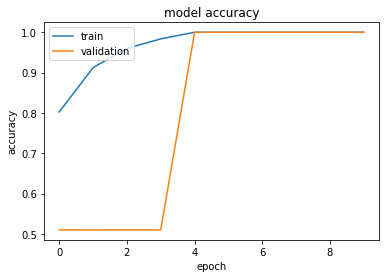

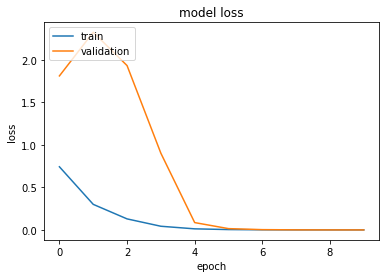

Epoch 1/10
1843/1843 - 4s - loss: 0.6354 - acc: 0.8330 - val_loss: 1.7707 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2201 - acc: 0.9330 - val_loss: 1.9465 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.0987 - acc: 0.9657 - val_loss: 1.8055 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 4s - loss: 0.0420 - acc: 0.9836 - val_loss: 1.5198 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 4s - loss: 0.0170 - acc: 0.9986 - val_loss: 0.7298 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 4s - loss: 0.0068 - acc: 0.9999 - val_loss: 0.1047 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 4s - loss: 0.0027 - acc: 0.9999 - val_loss: 0.0168 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0039 - val_acc: 0.9999
Epoch 9/10
1843/1843 - 3s - loss: 6.7176e-04 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 0.9999
Epoch 10/10
1843/1843 - 3s - loss: 4.4794e-04 - acc: 0.9999 - val_loss: 4.8003e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


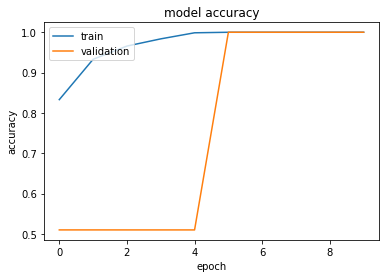

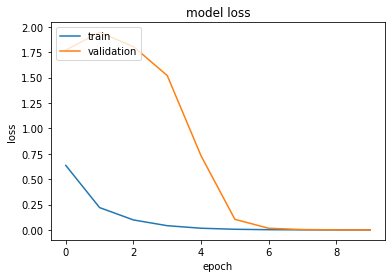

(276416, 1, 56) (276416, 12) (40000, 1, 56) (40000, 12) (110000, 1, 56) (110000, 12)
Epoch 1/10
1843/1843 - 5s - loss: 0.9339 - acc: 0.7555 - val_loss: 1.6664 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 5s - loss: 0.2928 - acc: 0.9138 - val_loss: 2.2252 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 4s - loss: 0.1217 - acc: 0.9620 - val_loss: 2.1476 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 4s - loss: 0.0385 - acc: 0.9870 - val_loss: 1.5484 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 4s - loss: 0.0107 - acc: 0.9999 - val_loss: 0.2125 - val_acc: 0.9901
Epoch 6/10
1843/1843 - 4s - loss: 0.0035 - acc: 0.9999 - val_loss: 0.0095 - val_acc: 1.0000
Epoch 7/10
1843/1843 - 4s - loss: 0.0014 - acc: 0.9999 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 8/10
1843/1843 - 4s - loss: 7.3044e-04 - acc: 0.9999 - val_loss: 4.3075e-04 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 4s - loss: 5.0037e-04 - acc: 0.9999 - val_loss: 2.0002e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 4s - loss: 3.7812e-04 - acc: 0.9999 - val_loss:

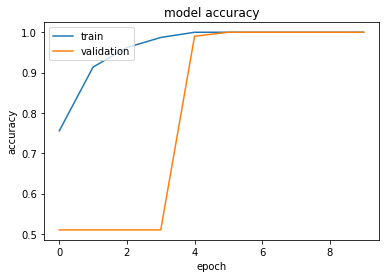

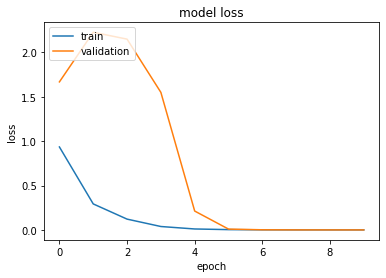

Epoch 1/10
1843/1843 - 5s - loss: 0.7747 - acc: 0.7930 - val_loss: 1.6859 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 4s - loss: 0.2546 - acc: 0.9231 - val_loss: 2.1020 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 4s - loss: 0.1100 - acc: 0.9625 - val_loss: 1.9438 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 4s - loss: 0.0452 - acc: 0.9834 - val_loss: 1.6133 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 5s - loss: 0.0151 - acc: 0.9986 - val_loss: 0.8806 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 4s - loss: 0.0050 - acc: 0.9999 - val_loss: 0.0570 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 5s - loss: 0.0019 - acc: 0.9999 - val_loss: 0.0048 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 4s - loss: 8.7970e-04 - acc: 0.9999 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 4s - loss: 5.4150e-04 - acc: 0.9999 - val_loss: 3.9023e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 4s - loss: 4.0721e-04 - acc: 0.9999 - val_loss: 2.0557e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


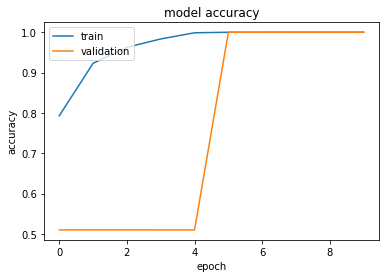

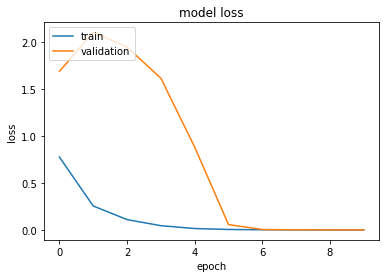

Epoch 1/10
1843/1843 - 3s - loss: 0.7114 - acc: 0.8145 - val_loss: 1.6505 - val_acc: 0.5101
Epoch 2/10
1843/1843 - 3s - loss: 0.2319 - acc: 0.9293 - val_loss: 2.1655 - val_acc: 0.5101
Epoch 3/10
1843/1843 - 3s - loss: 0.1108 - acc: 0.9650 - val_loss: 2.0242 - val_acc: 0.5101
Epoch 4/10
1843/1843 - 3s - loss: 0.0506 - acc: 0.9828 - val_loss: 1.4723 - val_acc: 0.5101
Epoch 5/10
1843/1843 - 3s - loss: 0.0228 - acc: 0.9944 - val_loss: 0.5531 - val_acc: 0.5101
Epoch 6/10
1843/1843 - 3s - loss: 0.0094 - acc: 0.9996 - val_loss: 0.0743 - val_acc: 0.9999
Epoch 7/10
1843/1843 - 3s - loss: 0.0036 - acc: 0.9999 - val_loss: 0.0155 - val_acc: 0.9999
Epoch 8/10
1843/1843 - 3s - loss: 0.0015 - acc: 0.9999 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 9/10
1843/1843 - 3s - loss: 7.7960e-04 - acc: 0.9999 - val_loss: 8.8779e-04 - val_acc: 1.0000
Epoch 10/10
1843/1843 - 3s - loss: 5.0135e-04 - acc: 0.9999 - val_loss: 2.8336e-04 - val_acc: 1.0000
Test Accuracy: 0.6891958423343173


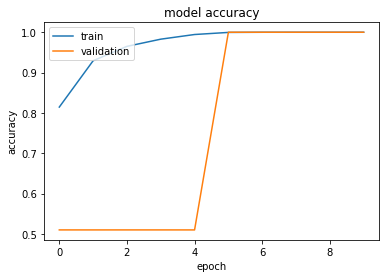

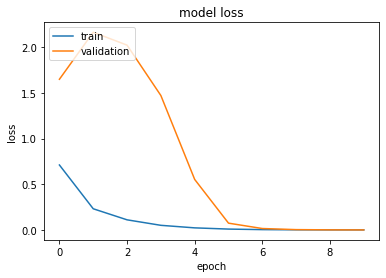

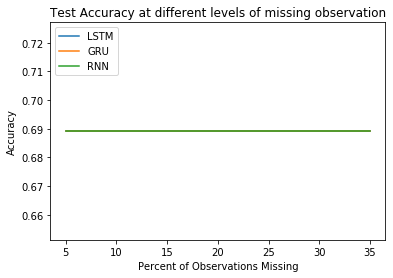

In [705]:
lst = range(5,40, 5)
test_acc_lstm = list()
test_acc_gru = list()
test_acc_simple = list()

for i in lst:
    dataset = copy.copy()
    dataset = noise(i/100, 0.1, dataset)
    #dataset.loc[:,:] = dataset.loc[:,:].ffill()
    train_X, train_y, val_X, val_y, test_X, test_y  = preprocess(dataset)
    print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    accuracy_lstm = lstm(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_lstm.append(accuracy_lstm)
    
    accuracy_gru = gru(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_gru.append(accuracy_gru)
    
    accuracy_simple = simpleRNN(train_X, train_y, val_X, val_y, test_X, test_y)
    test_acc_simple.append(accuracy_simple)
    
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.title('Test Accuracy at different levels of missing observation')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN'], loc='upper left')
pyplot.show()

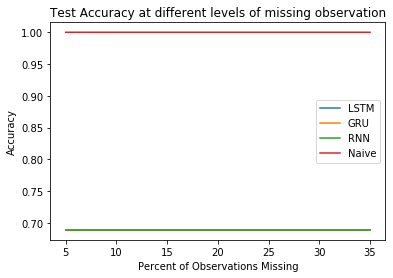

In [707]:
pyplot.plot(lst,test_acc_lstm)
pyplot.plot(lst,test_acc_gru)
pyplot.plot(lst,test_acc_simple)
pyplot.plot(lst,test_acc_naive)
pyplot.title('Test Accuracy at different levels of missing observation')
pyplot.ylabel('Accuracy')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['LSTM', 'GRU', 'RNN', 'Naive'], loc='best')
pyplot.show()

## 2-Layer LSTM

In [371]:
def lstm2(train_X, train_y, val_X, val_y, test_X, test_y):   
    # design network
    model = Sequential()
    model.add(LSTM(30, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(30))
    model.add(Dense(12, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)


    # fit network
    history = model.fit(train_X, train_y, epochs=10, batch_size=150, validation_data=(val_X, val_y), verbose=2, shuffle=False)


    testPredict = model.predict(test_X)
    #testPredict = scaler.inverse_transform(testPredict)
    #testY = scaler.inverse_transform([test_y])
    
    print(testPredict.shape)
    
    testScore = math.sqrt(mean_squared_error(test_y, testPredict)) #/test_y.shape[0]
    print('Test Score RMSE: ' + str(testScore))
    
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'validation'], loc='upper left')
    pyplot.show()
    return testScore

# NAIVE

In [525]:
def naive(dataset): 
    one_hot = pd.get_dummies(dataset['activityID'])
    dataset = dataset.drop('activityID',axis = 1)
    dataset = dataset.join(one_hot)  
    
    
    # load dataset
    values = dataset.values

    # ensure all data is float
    values = values.astype('float32')

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    
    reframed.drop(reframed.columns[[*range(0, 41)]], axis=1, inplace=True)
    reframed.drop(reframed.columns[[*range(13, 54)]], axis=1, inplace=True)
    
    y_pred = reframed.iloc[: , :13]
    y_target = reframed.iloc[: , 13:]
    
    testScore = math.sqrt(accuracy_score(y_target, y_pred)) #/test_y.shape[0]
    print('Test Accuracy: ' + str(testScore))
    
    return testScore


Test Score RMSE: 0.003196533648568739
Test Score RMSE: 0.00327957047183927
Test Score RMSE: 0.0033694394664119235
Test Score RMSE: 0.0034671253093684425
Test Score RMSE: 0.003573831992846502
Test Score RMSE: 0.0036910393302881602
Test Score RMSE: 0.003820590235847462
Test Score RMSE: 0.003964807350994027
Test Score RMSE: 0.004126703816148683
Test Score RMSE: 0.004310203001534409
Test Score RMSE: 0.004520581238387863
Test Score RMSE: 0.004765113862149263
Test Score RMSE: 0.005054170311502944
Test Score RMSE: 0.005403140964091993
Test Score RMSE: 0.005836040504694275
Test Score RMSE: 0.006393067297137478
Test Score RMSE: 0.007147676201070915
Test Score RMSE: 0.008253443776593428


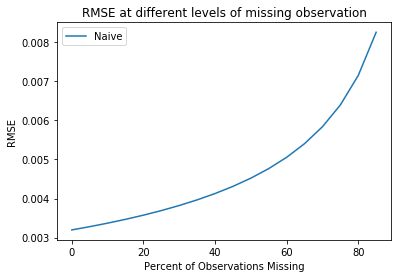

In [527]:
lst = range(0,90, 5)
test_acc_naive = list()

for i in lst:
    dataset = copy.copy()
    dataset = drop(i/100, dataset)
    #train_X, train_y, val_X, val_y, test_X, test_y  = preprocess(dataset)
    #print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    accuracy = naive(dataset)
    test_acc_naive.append(accuracy)
    
pyplot.plot(lst,test_acc_naive)
pyplot.title('RMSE at different levels of missing observation')
pyplot.ylabel('RMSE')
pyplot.xlabel('Percent of Observations Missing')
pyplot.legend(['Naive'], loc='upper left')
pyplot.show()